In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import os
import yaml
from pypsa.statistics import get_bus_and_carrier

import matplotlib.animation as animation

with open('../pypsa-earth/config.SEA_base.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
def rename_techs(label):
    if "H2" in label:
        label = "hydrogen storage"
    elif label == "solar":
        label = "solar PV"
    elif label == "offwind-ac":
        label = "offshore wind ac"
    elif label == "offwind-dc":
        label = "offshore wind dc"
    elif label == "onwind":
        label = "onshore wind"
    elif label == "ror":
        label = "hydroelectricity"
    elif label == "hydro":
        label = "hydroelectricity"
    elif label == "PHS":
        label = "hydroelectricity"
    elif "battery" in label:
        label = "battery storage"

    return label


preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "onshore wind",
        "offshore wind ac",
        "offshore wind dc",
        "solar PV",
        "solar thermal",
        "OCGT",
        "hydrogen storage",
        "battery storage",
    ]
)

In [12]:
carrier_groups = {
    "Offshore Wind (AC)": "Offshore Wind",
    "Offshore Wind (DC)": "Offshore Wind",
    "Open-Cycle Gas": "Gas",
    "Combined-Cycle Gas": "Gas",
    "Reservoir & Dam": "Hydro",
    "Pumped Hydro Storage": "Hydro",
}

nice_name = {"CCGT":"Combined-Cycle Gas",
            "coal": "Coal",
            "coal-CFB": "CFB Coal",
            "coal-SC": "Supercritical Coal",
            "coal-SubC": "Subcritical Coal",
            "coal-USC": "Ultra-Supercritical Coal",
            "oil": "Oil",
            "hydroelectricity": "Hydro Power",
            "offshore wind ac": "Offshore Wind (AC)",
            "offshore wind dc": "Offshore Wind (AC)",
            "onshore wind": "Onshore Wind",
            "solar PV": "Solar PV",
            "battery storage": "Battery Storage",
            "hydrogen storage": "Hydrogen Storage",
            "transmission lines": "Transmission Lines",
}

def plot_time_series_carrier(n, start_date, end_date, scenario_PyPSA, network_name, dec_label=False):
    optimized = n.statistics.energy_balance(groupby=get_bus_and_carrier, aggregate_time=False).T
    load_demand = abs(optimized[["Load"]].droplevel(0, axis=1).T.sum().T)
    optimized = optimized[["Generator", "Store"]].droplevel(0, axis=1)
    optimized = optimized.rename(columns=n.buses.country, level=0)
    optimized = optimized.rename(columns=carrier_groups, level=1)
    optimized = optimized.groupby(axis=1, level=[0, 1]).sum()
    
    df_carrier = optimized.T.groupby(optimized.columns.get_level_values(1)).sum().T
    #df_country = optimized.T.groupby(optimized.columns.get_level_values(0)).sum().T
    
    for c in df_carrier.columns:
        if (df_carrier[c] < 0).values.any():
            df_carrier[c + " Discharge"] = df_carrier[c].clip(lower=0)
            df_carrier[c + " Charge"] = df_carrier[c].clip(upper=0)
            df_carrier = df_carrier.drop(columns=c)
    
    #Set color
    colors = n.carriers.set_index("nice_name").color.where(
        lambda s: s != "", "lightgrey"
    )
    colors["Offshore Wind"] = colors["Offshore Wind (AC)"]
    colors["Gas"] = colors["Combined-Cycle Gas"]
    colors["Hydro"] = colors["Reservoir & Dam"]
    colors["Other"] = "lightgray"
    colors["Battery Storage Charge"] = colors["Battery Storage"]
    colors["Battery Storage Discharge"] = colors["Battery Storage"]
    colors["Hydrogen Storage Charge"] = colors["Hydrogen Storage"]
    colors["Hydrogen Storage Discharge"] = colors["Hydrogen Storage"]
    
    colors["load"] = "#ff0000"
    #Set ordering based on variable to base
    order = ((df_carrier.diff().abs().sum() / df_carrier.sum()).sort_values().index)
    df_carrier = df_carrier[order]
    
    #cut into the specific timesteps
    
    df_carrier = df_carrier[pd.Timestamp(start_date):pd.Timestamp(end_date)]
    load_demand = load_demand[pd.Timestamp(start_date):pd.Timestamp(end_date)]

    #kWh to MWh
    df_carrier = df_carrier/1e3
    load_demand = load_demand/1e3

    df_carrier.loc[:,"Hydrogen Storage Charge"] = 0
    #remove if smaller than 1 MWh
    df_carrier = df_carrier.loc[:,abs(df_carrier.sum()) > 1]

    
    
    fig, axes = plt.subplots(figsize=(8,4))

    
    df_carrier.plot.area(ax = axes, legend=False, color = [colors[c] for c in df_carrier.columns])

    load_demand.plot(ax = axes, color = "black", linestyle='dashed')

    axes.set_ylim([-1200, 2400])
    axes.set_ylabel("Energy Balance [MW]")
    axes.set_xlabel("")

    #handles, labels = axes.get_legend_handles_labels()
    #handles.reverse()
    #labels.reverse()
    #axes.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.4), frameon=False)

    df_color = pd.DataFrame(data = {"color" : [n.carriers.loc[c,"color"] for c in n.generators.query("carrier != 'load'").carrier.unique()]}, 
                            index = n.generators.query("carrier != 'load'").carrier.unique())

    df_color = df_color.groupby(df_color.index.map(rename_techs)).sum()

    df_color.loc["battery storage","color"] = colors["Battery Storage"]
    df_color.loc["hydrogen storage","color"] = colors["Hydrogen Storage"]
    df_color.loc["transmission lines","color"] = '#70af1d'
    
    df_color.index.intersection(preferred_order).append(df_color.index.difference(preferred_order))

    ncol = 4
    if dec_label:
        df_color = df_color.drop(["coal","coal-CFB","coal-SC","coal-SubC","coal-USC","lignite","oil"])
        ncol = 4

    #df_color = df_color.rename(index = nice_name)

    pypsa.plot.add_legend_patches(ax=axes, colors = df_color.color, labels = df_color.index,
                                 legend_kw = {'loc':"upper center",'bbox_to_anchor':(0.5, -0.15), 'frameon':False, 'ncol':ncol, 'title':"Components", 
                                              'title_fontproperties':{'weight':'bold'}})

    ann = 22
    annonate_x = load_demand.index[ann]
    annonate_y = load_demand.iloc[ann]
    
    axes.annotate('Load/h',
                xy=(annonate_x, annonate_y),  # theta, radius
                xytext=(annonate_x, annonate_y+650),    # fraction, fraction
                arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth = 5),
                horizontalalignment='center',
                verticalalignment='top',
                )

    axes.set_title(f'{scenario_PyPSA}{dec_name}_2050', 
              loc='left', 
              x=0.02, 
              y=0.90,
              fontsize=9
             )

    axes.grid(axis="y")
    fig.tight_layout()
    
    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_time_series.svg',bbox_inches='tight')


## Stagnant Technology

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


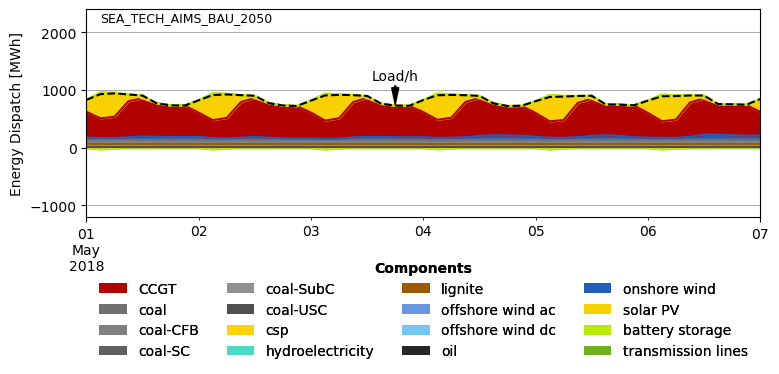

In [31]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-final_V1"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"
# network_name = "elec_s_200_ec_lcopt_Co2L0.297516-3H"
# network_name = "elec_s_200_ec_lcopt_Co2L0.029752-3H"

year = 2050

n = pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA}{year}/networks/{network_name}.nc")

start_date = '2018-05-01'
end_date = '2018-05-07'

scenario_PyPSA = "SEA_TECH_AIMS_"

df = plot_time_series_carrier(n, start_date, end_date, scenario_PyPSA, network_name, dec_label=False)

## Business as Usual

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


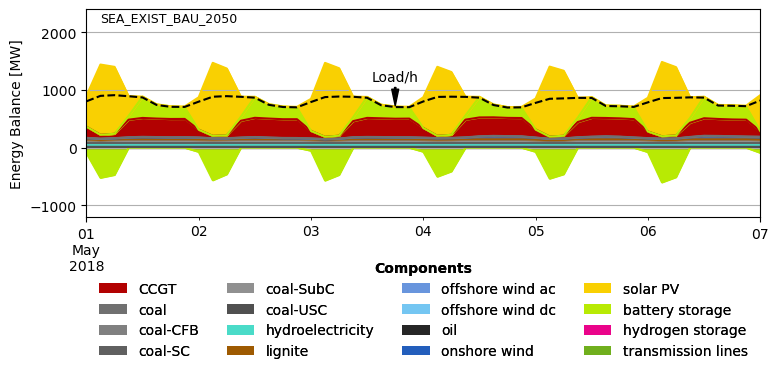

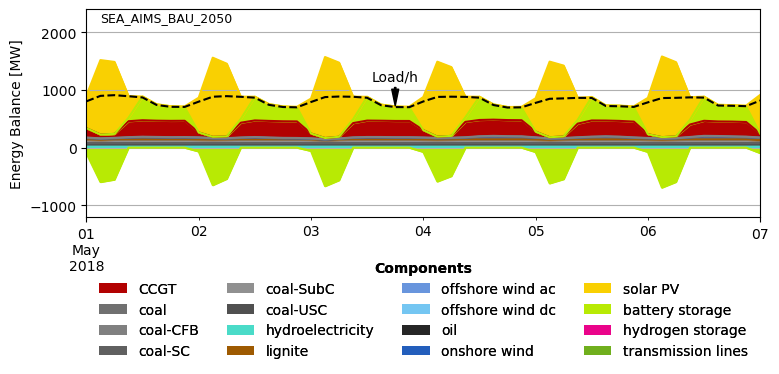

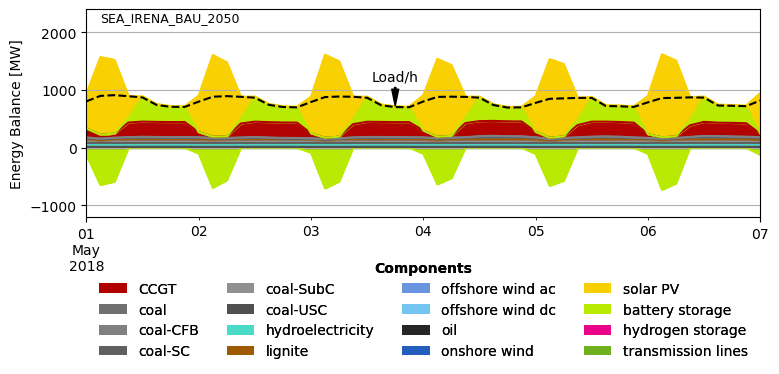

In [15]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"
# network_name = "elec_s_200_ec_lcopt_Co2L0.297516-3H"
# network_name = "elec_s_200_ec_lcopt_Co2L0.029752-3H"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios} 

start_date = '2018-05-01'
end_date = '2018-05-07'

for scenario in scenarios:
    df = plot_time_series_carrier(fn[scenario], start_date, end_date, scenario, network_name, dec_label=False)

In [ ]:
nice_name = {"CCGT":"Combined-Cycle Gas",
            "coal": "Coal",
            "coal-CFB": "Circulating Fluidized Bed Coal",
            "coal-SC": "Supercritical Coal",
            "coal-SubC": "Subcritical Coal"
            "coal-USC": "Ultra-Supercritical Coal",
            "hydroelectricity": "Hydro Power",
            "offshore wind ac": "Offshore Wind (AC)",
            "offshore wind dc": "Offshore Wind (AC)",
            "onshore wind": "Onshore Wind",
            "solar PV": "Solar PV",
            "battery storage": "Battery Storage"
            "hydrogen storage": "Hydrogen Storage"
            "transmission lines": "Transmission Lines"
}

# Stable Elec

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


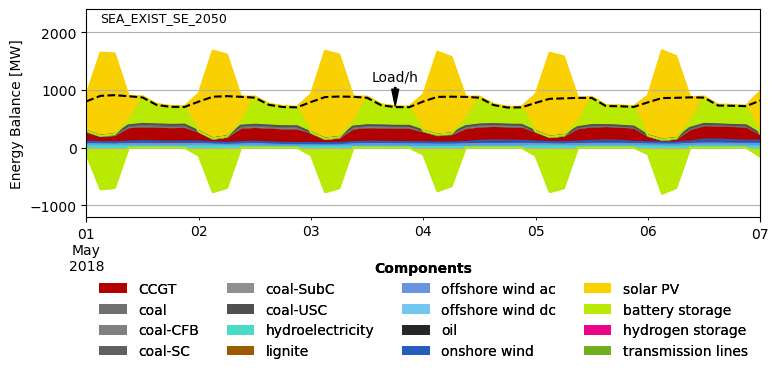

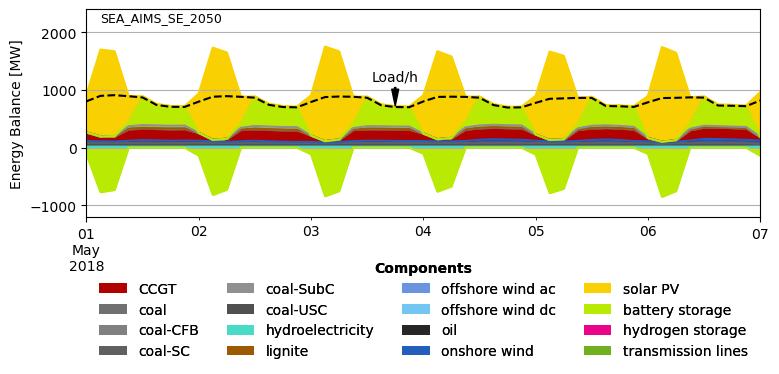

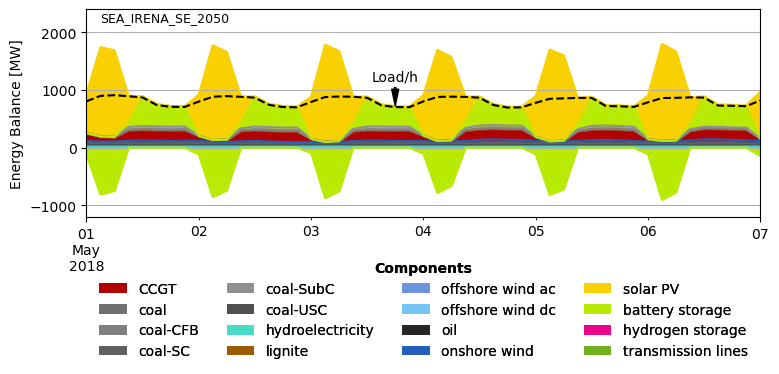

In [11]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.500924-3H"
dec_name = "SE"
# network_name = "elec_s_200_ec_lcopt_Co2L0.297516-3H"
# network_name = "elec_s_200_ec_lcopt_Co2L0.029752-3H"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios} 

start_date = '2018-05-01'
end_date = '2018-05-07'

for scenario in scenarios:
    df = plot_time_series_carrier(fn[scenario], start_date, end_date, scenario, network_name, dec_label=False)

# Decarbonize

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


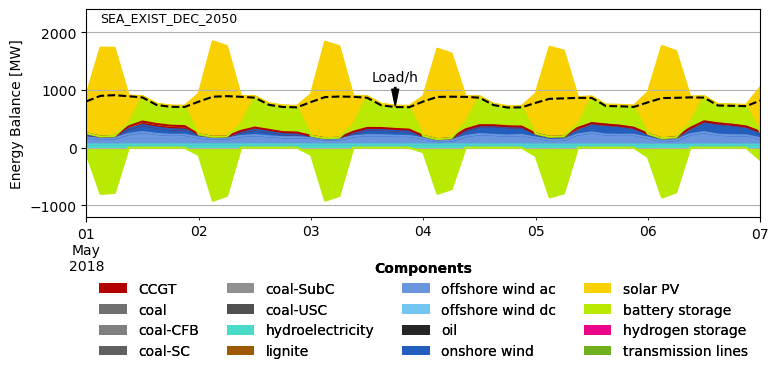

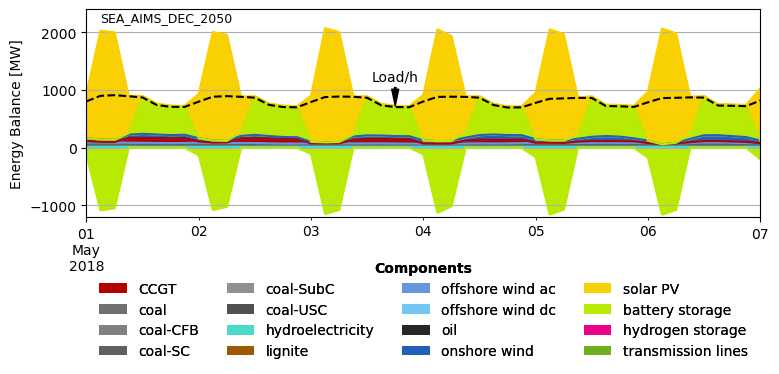

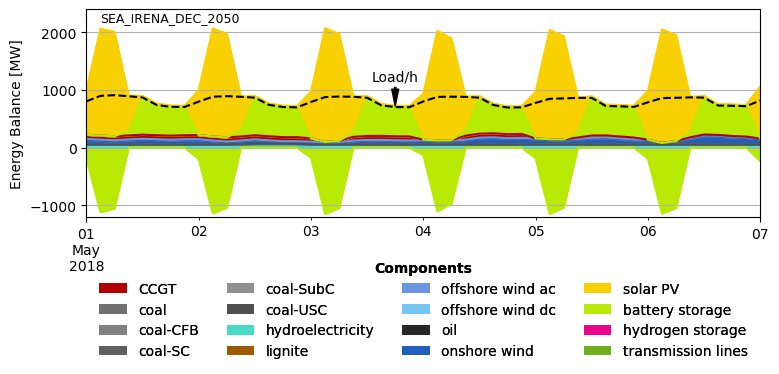

In [13]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.050092-3H"
dec_name = "DEC"
# network_name = "elec_s_200_ec_lcopt_Co2L0.297516-3H"
# network_name = "elec_s_200_ec_lcopt_Co2L0.029752-3H"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios} 

start_date = '2018-05-01'
end_date = '2018-05-07'

for scenario in scenarios:
    df = plot_time_series_carrier(fn[scenario], start_date, end_date, scenario, network_name, dec_label=False)